In [1]:
%matplotlib inline

In [97]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

##
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
import scipy.stats as stats

#
from astropy.io import fits
import astropy.units as u
import astropy.wcs as wcs

#
import pandas as pd

In [3]:
import sys
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/HCPy/')
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/HCPy/RadfilStatistics')
sys.path.insert(0, '/Users/hopechen/Documents/projects/git_projects/radfil/')

from HCPy import *
from ShapeStatistics import ShapeStatistics
from LinearStatistics import LinearStatistics
from radfil import radfil_class, profile_tools, styles

____
# Goal

The goal of this notebook is to develop `LinearStatistics` for `RadFil`.  It will be a stand-alone, and takes a radfil object.

## Original Data

In [4]:
direcData = '/Users/hopechen/Documents/projects/git_projects/data/'
data = fits.open(direcData+'moment0_11_1stfinger_small.fits')[0]

image, header = data.data, data.header
wcs0 = wcs.WCS(header)

##
lower = np.percentile(image, 75.)
mask = (image >= lower)

### polarization table
dataB = fits.open(direcData+'oriona_cat12as_debias_forKM_larger.FIT')[1]
tableB = pd.DataFrame(dataB.data)
tableB['RA'], tableB['DEC'] = np.degrees(tableB['RA']), np.degrees(tableB['DEC'])

## Create maps for each column, with the same shapes as the (cropped) GBT/VLA map

In [7]:
# make fits maps for each column
##
xgrid, ygrid = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
##
coords = [(tableB['RA'][i], tableB['DEC'][i])
          for i in range(len(tableB))]
coordsPix = wcs0.wcs_world2pix(coords, 0.)
distancePix = np.array([np.hypot(xgrid - coordPix[0], ygrid - coordPix[1])
                        for coordPix in coordsPix])
##
indexMap = np.argmin(distancePix, axis = 0)

##
for col in tableB.keys()[4:]:
    imageProperty = np.zeros(image.shape)*np.nan
    
    for i in range(len(tableB)):
        imageProperty[indexMap == i] = tableB[col].values[i]
        
    hdu = fits.PrimaryHDU(imageProperty,
                          header = header)
    hdu = fits.HDUList([hdu])
    hdu.writeto(direcData+'oriona_cat12as_debias_forKM_larger_maps/'+col+'.fits')

## RadFil

### Run the original RadFIl

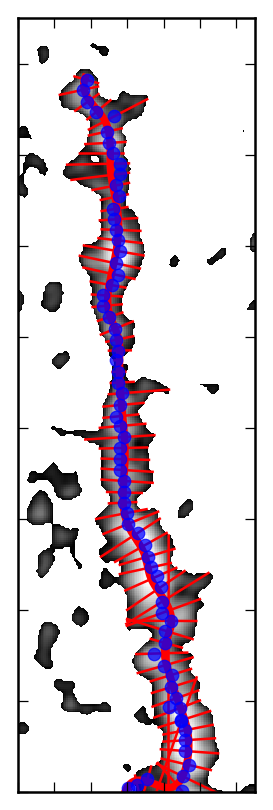

In [8]:
radfil = radfil_class.radfil(image, mask, header = header, distance = 414.)
radfil.make_fil_spine(beamwidth = 6)
radfil.build_profile(cutdist=0.1, samp_int=6, bins=40, shift=True, wrap=False)

### Adjust the angles stored in the table (and thus the newly created map) and run the statistics

In [149]:
PAB = fits.open(direcData+'oriona_cat12as_debias_forKM_larger_maps/ANG.fits')[0].data
PAB += 90.

radfil.cutdist = 0.02*u.pc

sstats = ShapeStatistics(radfil)

### Use `sstats.points` to query the angles from the map

In [152]:
PAB_list = np.array([PAB[int(round(sstats.points[i][1])), int(round(sstats.points[i][0]))]
                     for i in range(1, len(sstats.points)-1)])

### Flip some of the data points to make it look continuous

***The data points near the right of the plot (the north side) are debatable in terms of how to make them look continuous.***

In [153]:
PAB_cont = PAB_list.copy()
PAB_cont[PAB_cont < 110.] += 180.
PAB_cont[PAB_cont >= 240.] -= 180.

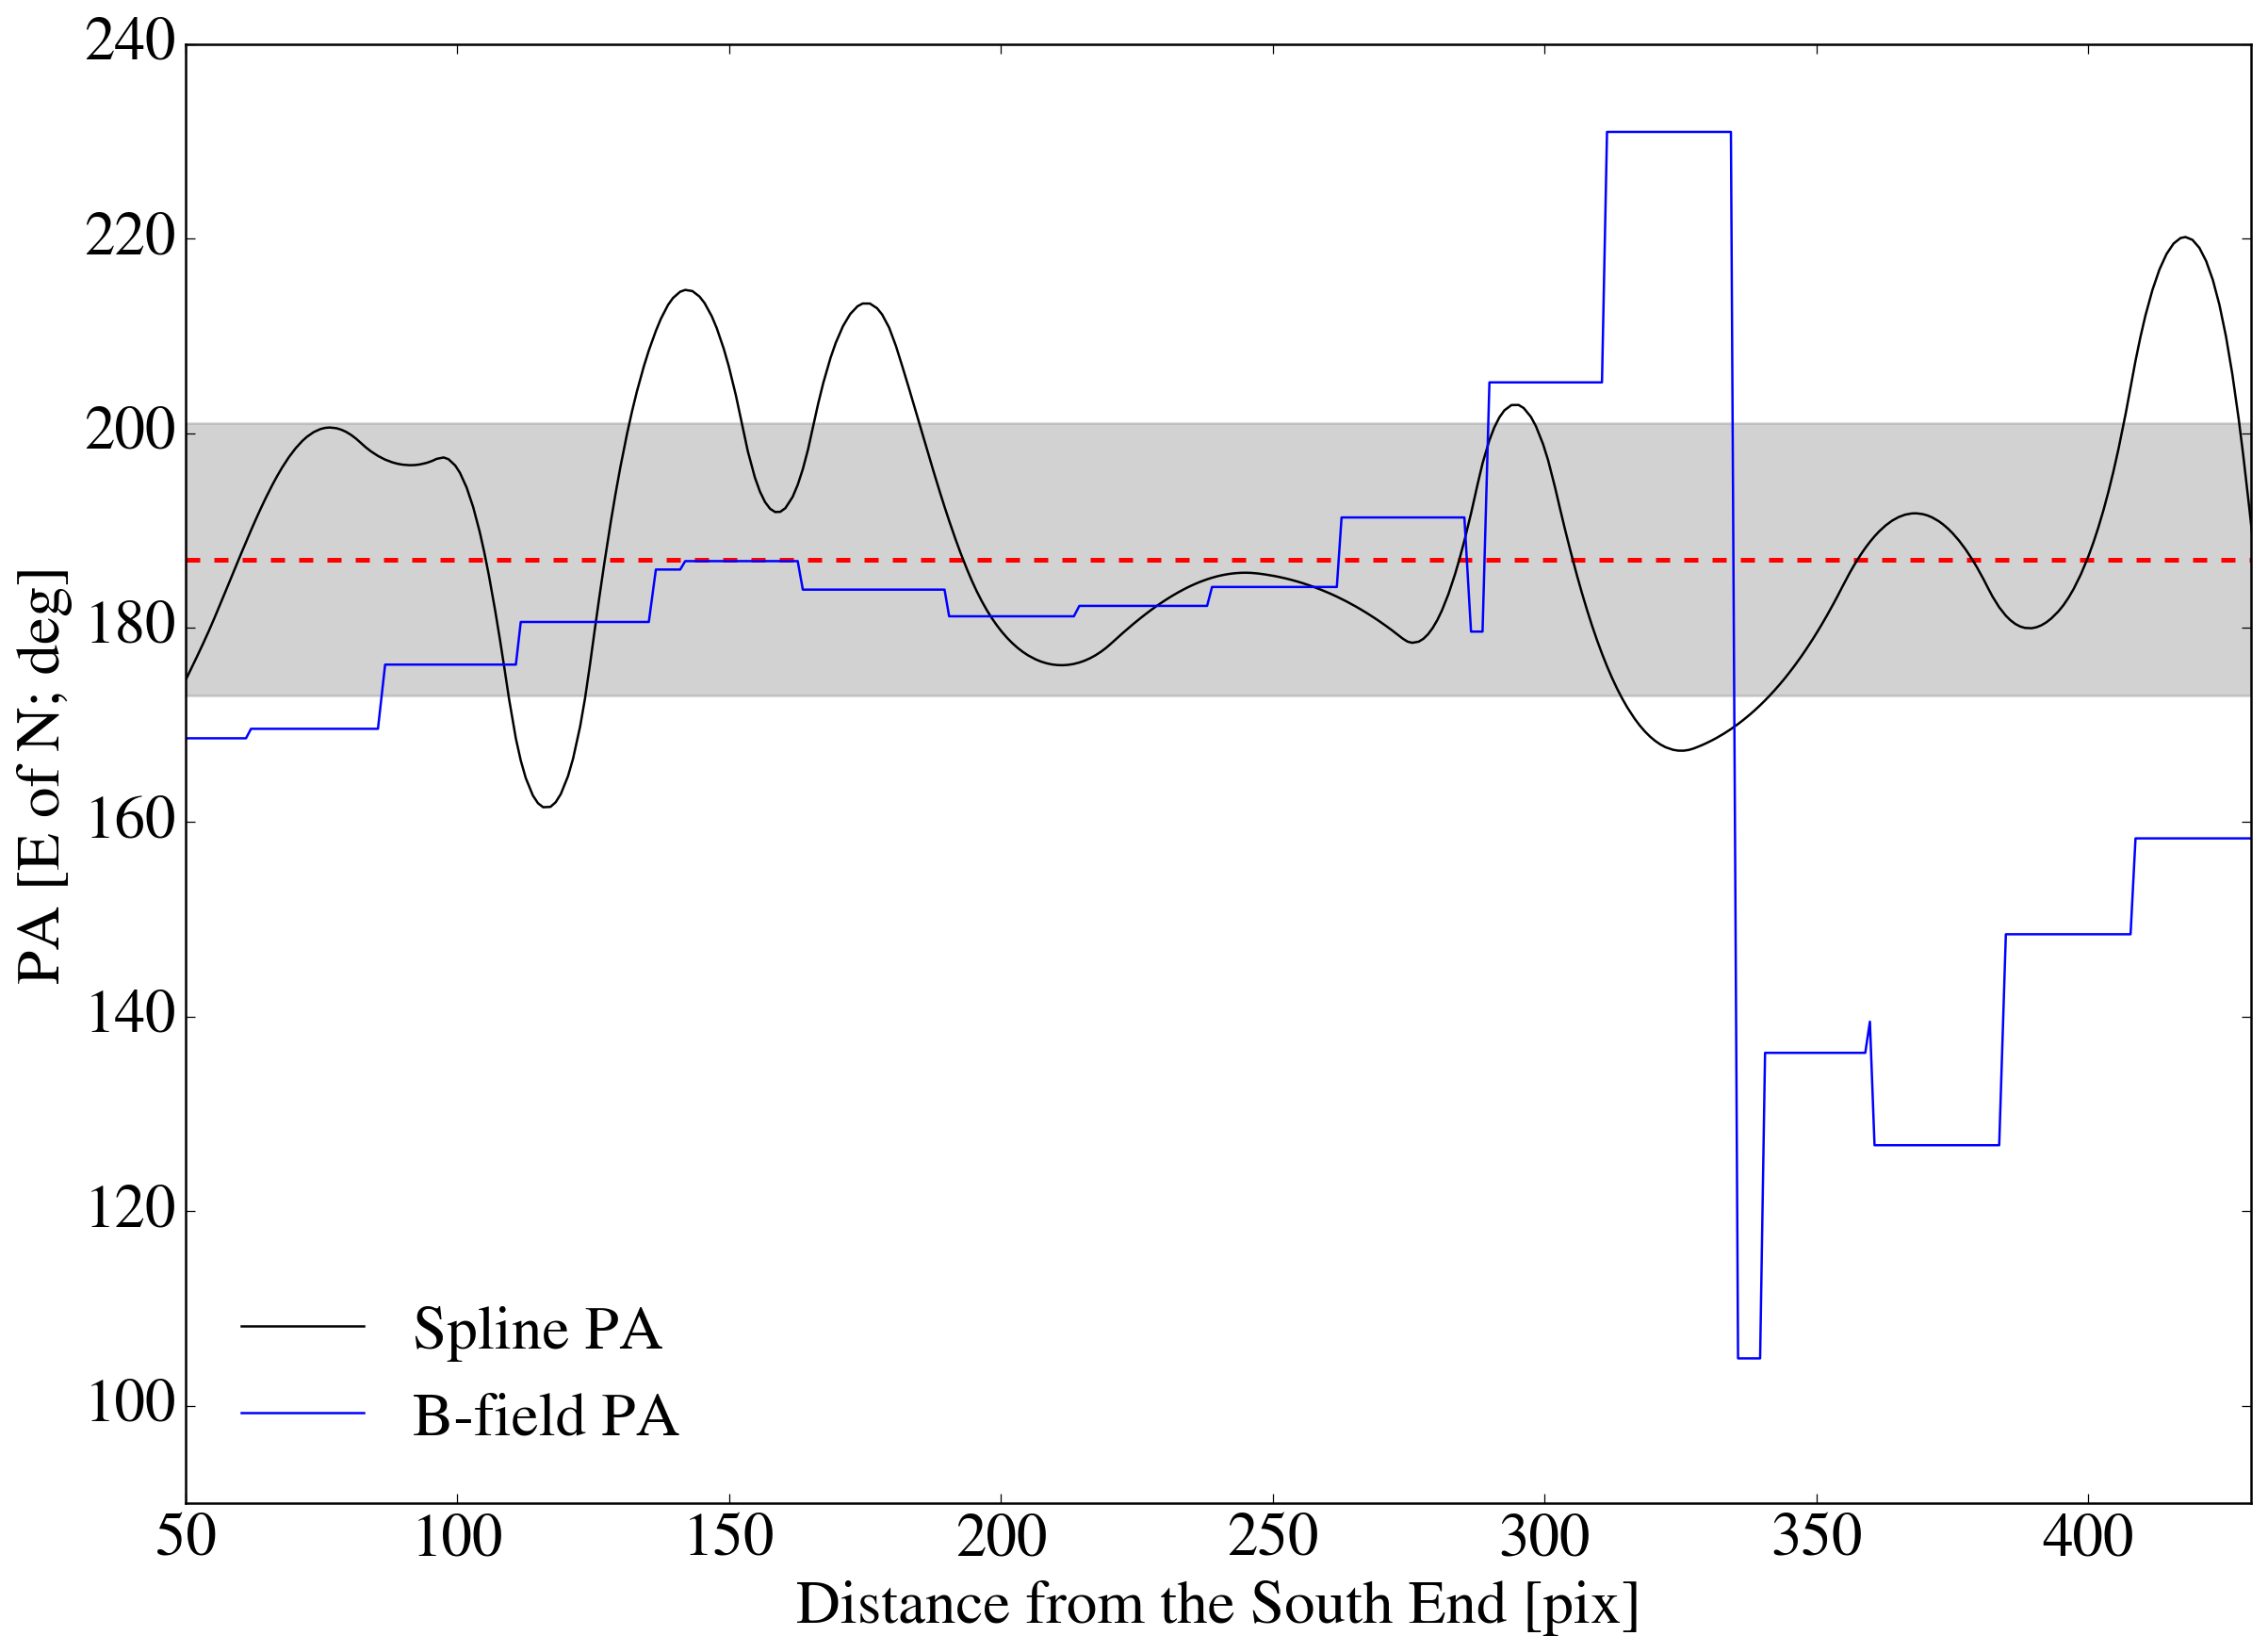

In [168]:
fig = plt.figure(figsize = (14., 10.))
ax = fig.gca()
ax.set_xlim(50., 430.)
ax.set_xlabel('Distance from the South End [pix]')
ax.set_ylim(90., 240.)
ax.set_ylabel('PA [E of N; deg]')

ax.plot(sstats.distance, sstats.PA,
        'k-',
        label = 'Spline PA')
ax.plot(sstats.distance, PAB_cont,
        'b-',
        label = 'B-field PA')
ax.fill_between(ax.get_xlim(), [187.-14.]*2, [187.+14.]*2,
                color = 'gray',
                alpha = .35)

ax.hlines(187., *ax.get_xlim(),
          color = 'r',
          linestyle = '--',
          linewidth = 2.)

plt.legend(loc = 'lower left')

____
## RadFil

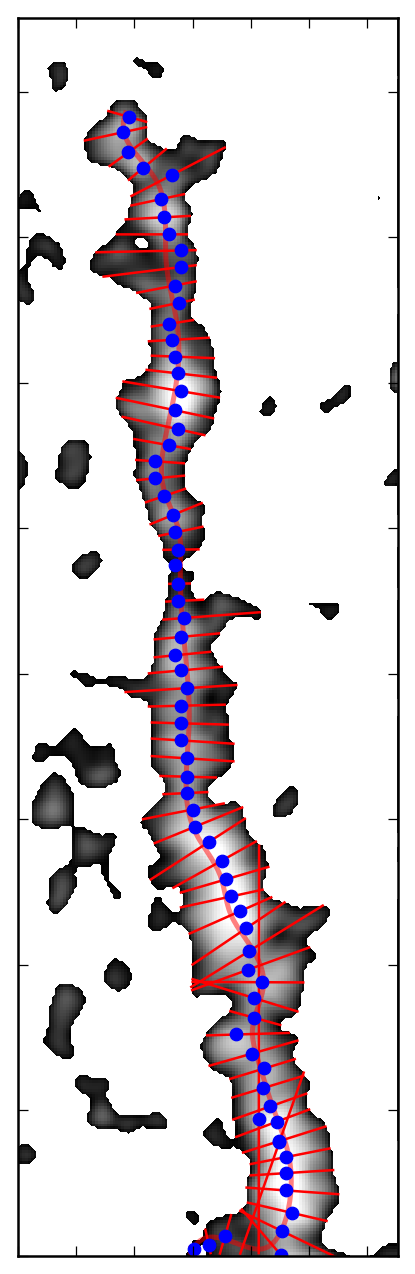

In [5]:
radfil = radfil_class.radfil(image, mask, header = header, distance = 414.)
radfil.make_fil_spine(beamwidth = 6)
radfil.build_profile(cutdist=0.1, samp_int=6, bins=40, shift=True, wrap=False)

____
## LinearStatistics

1. Whether to cut: Maybe.  We may have to, since there is the fractal problem for using pixels.

2. The default of samp_int: 3, which almost always proudce a minimum size >= 10.

3. Intermediate products: a list of masks, a list of (sets of) numbers, a list of distances along the spline.

4. Functions:

    a. For the current map:
        * Statistics: moments and percentiles.
    b. For another map (of the same shape):
        * Statistics: moments and percentiles.

In [9]:
sstats = ShapeStatistics(radfil)
lstats = LinearStatistics(radfil)
medians = lstats.statistics(statistic = ('percentile', 50.)).stats.copy()
stds = np.sqrt(lstats.statistics(statistic = ('moment', 2)).stats.copy())

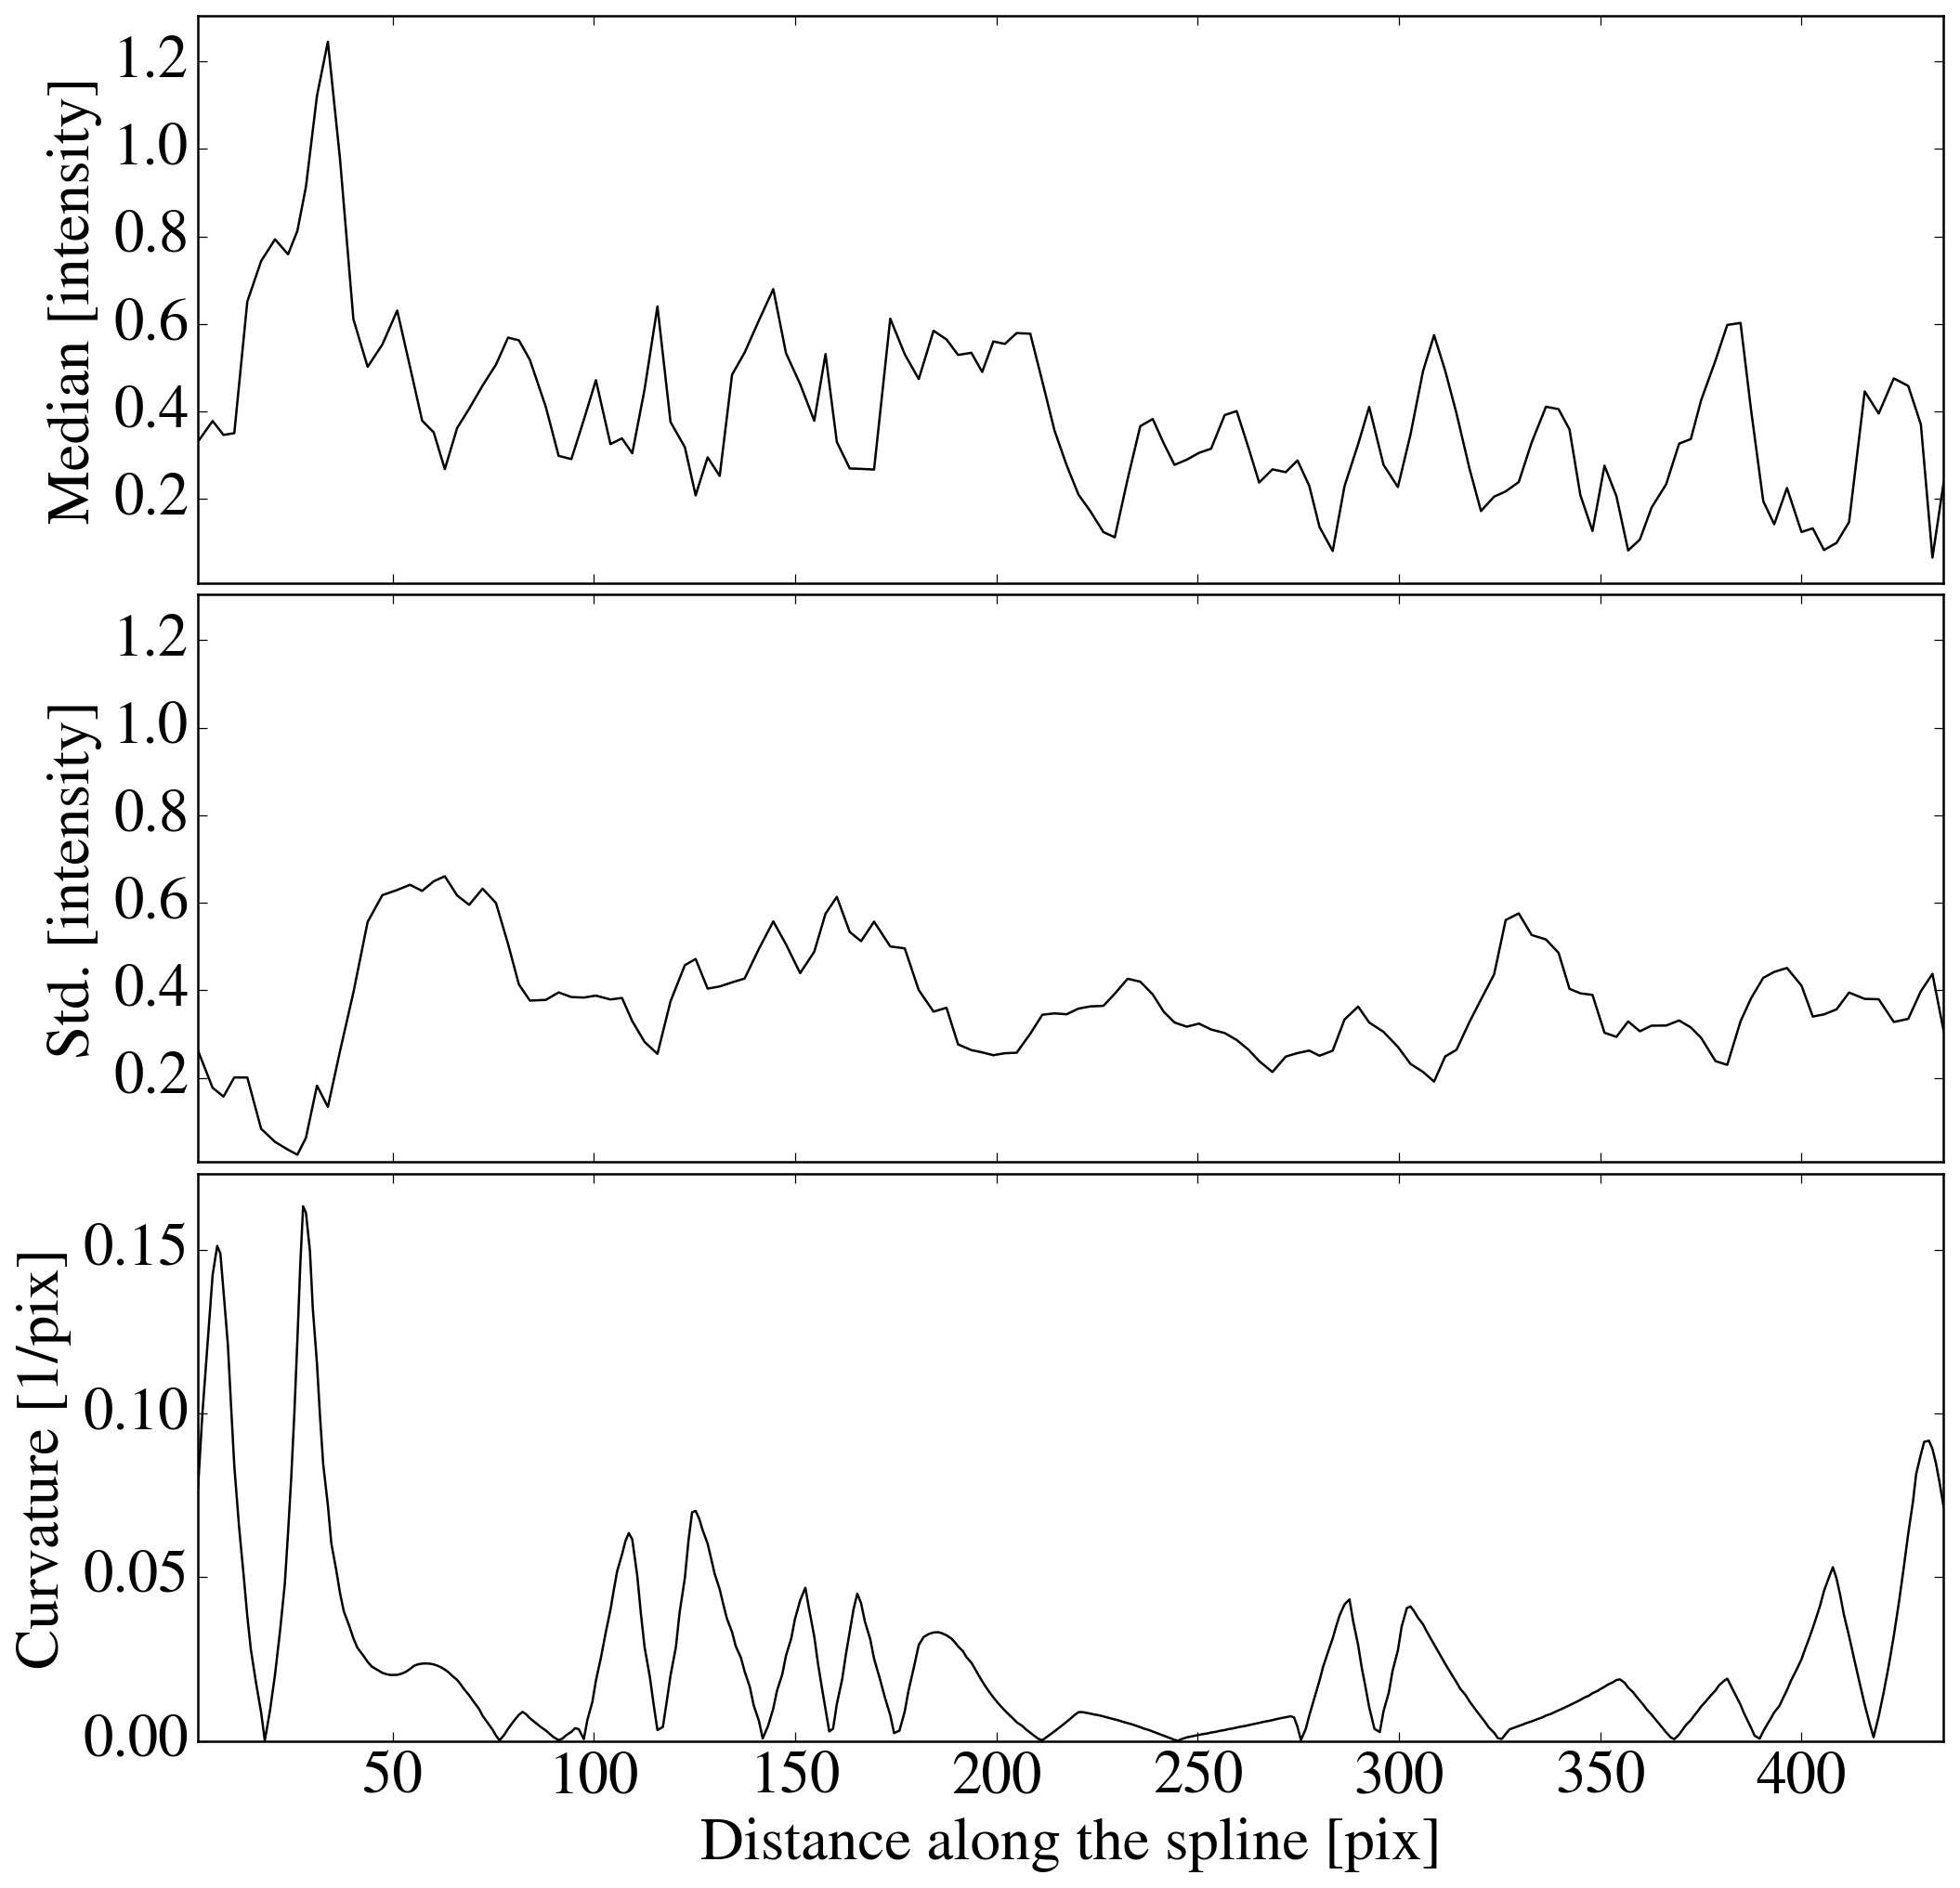

In [10]:
fig, ax = plt.subplots(figsize = (12., 12.),
                       nrows = 3)

# median
axis = ax[0]
axis.set_ylim(medians.min()-.05*(medians.max()-medians.min()),
              medians.max()+.05*(medians.max()-medians.min()))
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(lstats.distance, medians, 'k-')
##
#axis.set_yticks(np.arange(45.*(axis.get_ylim()[0]//45.+1), axis.get_ylim()[1], 45.))
axis.set_xticklabels([])
axis.set_ylabel('Median [intensity]')

# PA rate
axis = ax[1]
axis.set_ylim(medians.min()-.05*(medians.max()-medians.min()),
              medians.max()+.05*(medians.max()-medians.min()))
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(lstats.distance, stds, 'k-')
##
#axis.set_yticks(np.arange(45.*(axis.get_ylim()[0]//45.+1), axis.get_ylim()[1], 45.))
axis.set_xticklabels([])
axis.set_ylabel('Std. [intensity]')

# Menger curvature
axis = ax[2]
axis.set_ylim(0., sstats.mcurvature.max()+.01)
axis.set_xlim(sstats.distance.min(), sstats.distance.max())
axis.plot(sstats.distance, sstats.mcurvature, 'k-')
##
axis.set_yticks(np.arange(.05*(axis.get_ylim()[0]//.05), axis.get_ylim()[1], .05))
axis.set_xlabel('Distance along the spline [pix]')
axis.set_ylabel('Curvature [1/pix]')